SETUP

## Imports

In [3]:
import warnings, requests, zipfile, io #Controla y gestiona advertencias, peticiones HTTP, lee y crea archivos zip, archivos de memoria
warnings.simplefilter('ignore') #ocultar warnings

!{sys.executable} -m pip install sagemaker pandas numpy --upgrade #Se instala y actualiza SageMaker, Pandas y Numpy
!pip3 install -U sagemaker 

import pandas as pd  #Para el manejo de los datasets
import numpy as np  #Para manejo de arreglos numéricos
import matplotlib.pyplot as plt  #Para hacer gráficas
import io    #Para manejar archivos de memoria
import os    #Permite interactuar con el sistema operativo
import sys  #Interactúa con el intérprete de Python
import time #sirve para trabajar con tiempos, pausas y mediciones de duración en Python
import json #trabaja con datos en formato JSON (JavaScript Object Notation)
from IPython.display import display #muestra objetos de manera legible dentro de entornos interactivos
from time import strftime, gmtime  #formatear fechas y horas en formato UTC
from sagemaker.inputs import TrainingInput #origen los datos de entrenamiento y cómo deben ser leídos
from sagemaker.serializers import CSVSerializer #convierte datos de Python en texto CSV antes de enviarlos al endpoint


/bin/sh: {sys.executable}: command not found
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 171.5 MB/s  0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached gitpython-3.1.45-py3-none-any.whl.metadata (13 kB)
  Using cached gitdb-4.0.12-py3-none-any.whl.metadata (1.2 kB)
  Using cached smmap-5.0.2-py3-none-any.whl.metadata (4.3 kB)
INFO: pip is looking at multiple versions of opentelemetry-proto to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of opentelemetry-proto to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press 

Matplotlib is building the font cache; this may take a moment.


In [12]:
import sagemaker

sess = sagemaker.Session()  #crea una sesión de Amazon SageMaker
bucket = sess.default_bucket() #Obtiene el bucket por defecto
prefix = "sagemaker/DEMO-xgboost-churn" #Define un prefijo de carpeta dentro del bucket S3

# Define IAM role
import boto3 #Importa el SDK oficial de AWS para Python.
import re  #Importa el módulo de expresiones regulares de Python.
from sagemaker import get_execution_role  #Importa una función especial que obtiene el IAM role asignado al entorno

role = get_execution_role()#Obtiene el IAM Role que el entorno usa para ejecutar SageMaker.

DATA

CREATE S3 BUCKET:

To store the dataset called churn.txt


In [13]:
session = sagemaker.Session()                 # Crear una sesión de SageMaker
region = session.boto_region_name            # Obtener la región configurada para la sesión

s3 = boto3.client("s3", region_name=region)  # Crear un cliente de S3 en la misma región

bucket_name = "alejo-ml-projects-bucket"     # Nombre del bucket que queremos crear

# Crear el bucket (S3 usa una sintaxis diferente si la región es us-east-1)
#if region == "us-east-1":
    #    s3.create_bucket(Bucket=bucket_name)     # Crear bucket sin configuración adicional
    
#else:
    #    s3.create_bucket(
    #        Bucket=bucket_name,
    #        CreateBucketConfiguration={"LocationConstraint": region}  # Especificar región
    #    )

print("Bucket created:", bucket_name)         # Confirmar creación del bucket


Bucket created: alejo-ml-projects-bucket


In [15]:
file_name = "churn.txt"                          # Nombre del archivo local a subir

bucket_name = "alejo-ml-projects-bucket"         # Nombre del bucket donde se subirá

s3_path = "datasets/churn/churn.txt"             # Ruta dentro del bucket S3

s3.upload_file(file_name, bucket_name, s3_path)  # Subir el archivo local al bucket en la ruta indicada

print("Uploaded to", f"s3://{bucket_name}/{s3_path}")   # Imprimir la ubicación final del archivo en S3


Uploaded to s3://alejo-ml-projects-bucket/datasets/churn/churn.txt


EXPLORE THE DATA

In [16]:
s3.download_file(bucket_name, s3_path, "churn_ml.txt")
print("Descargado como churn_ml.txt")
df = pd.read_csv(f"s3://{bucket_name}/{s3_path}")
df.head()

Descargado como churn_ml.txt


,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,PA,163,806,403-2562,no,yes,300,8.162204,3,7.579174,...,4,6.508639,4.065759,100,5.111624,4.928160,6,5.673203,3,True.
1,SC,15,836,158-8416,yes,no,0,10.018993,4,4.226289,...,0,9.972592,7.141040,200,6.436188,3.221748,6,2.559749,8,False.
2,MO,131,777,896-6253,no,yes,300,4.708490,3,4.768160,...,3,4.566715,5.363235,100,5.142451,7.139023,2,6.254157,4,False.
3,WY,75,878,817-5729,yes,yes,700,1.268734,3,2.567642,...,5,2.333624,3.773586,450,3.814413,2.245779,6,1.080692,6,False.
4,WY,146,878,450-4942,yes,no,0,2.696177,3,5.908916,...,3,3.670408,3.751673,250,2.796812,6.905545,4,7.134343,6,True.


In [17]:
len(df.columns)   # Retorna el número total de columnas del DataFrame df
df.shape          # Mostrar columnas y filas

(5000, 21)

col_0,% observations
State,
AK,0.0170
AL,0.0200
AR,0.0220
AZ,0.0180
CA,0.0208
CO,0.0182
CT,0.0178
DC,0.0224
DE,0.0182


col_0,% observations
Phone,
100-2030,0.0002
100-2118,0.0002
100-3505,0.0002
100-5224,0.0002
101-3371,0.0002
...,...
999-3178,0.0002
999-5498,0.0002
999-5816,0.0002


col_0,% observations
Int'l Plan,
no,0.5014
yes,0.4986


col_0,% observations
VMail Plan,
no,0.4976
yes,0.5024


col_0,% observations
Churn?,
False.,0.5004
True.,0.4996


,Account Length,Area Code,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,101.675800,773.791400,226.680000,5.518757,3.50460,5.018902,5.026199,3.140400,5.017557,4.000917,224.790000,5.023490,5.025876,5.475400,4.328242,5.525800
std,57.596762,63.470888,273.998527,3.433485,1.68812,2.195759,2.135487,2.525621,2.127857,1.631001,97.302875,1.748900,1.019302,1.877045,2.440311,2.041217
min,1.000000,657.000000,0.000000,0.000215,0.00000,0.004777,0.004659,0.000000,0.013573,0.008468,0.000000,0.054863,1.648514,0.000000,0.000769,0.000000
25%,52.000000,736.000000,0.000000,2.682384,2.00000,3.470151,3.588466,1.000000,3.529613,2.921998,150.000000,3.873157,4.349726,4.000000,2.468225,4.000000
50%,102.000000,778.000000,0.000000,5.336245,3.00000,4.988291,5.145656,3.000000,5.006860,3.962089,200.000000,5.169154,5.034905,5.000000,4.214058,6.000000
75%,151.000000,806.000000,400.000000,7.936151,5.00000,6.559750,6.552962,5.000000,6.491725,5.100128,300.000000,6.272015,5.716386,7.000000,5.960654,7.000000
max,200.000000,878.000000,1300.000000,16.897529,10.00000,12.731936,13.622097,14.000000,12.352871,10.183378,550.000000,10.407778,8.405644,12.000000,14.212261,13.000000


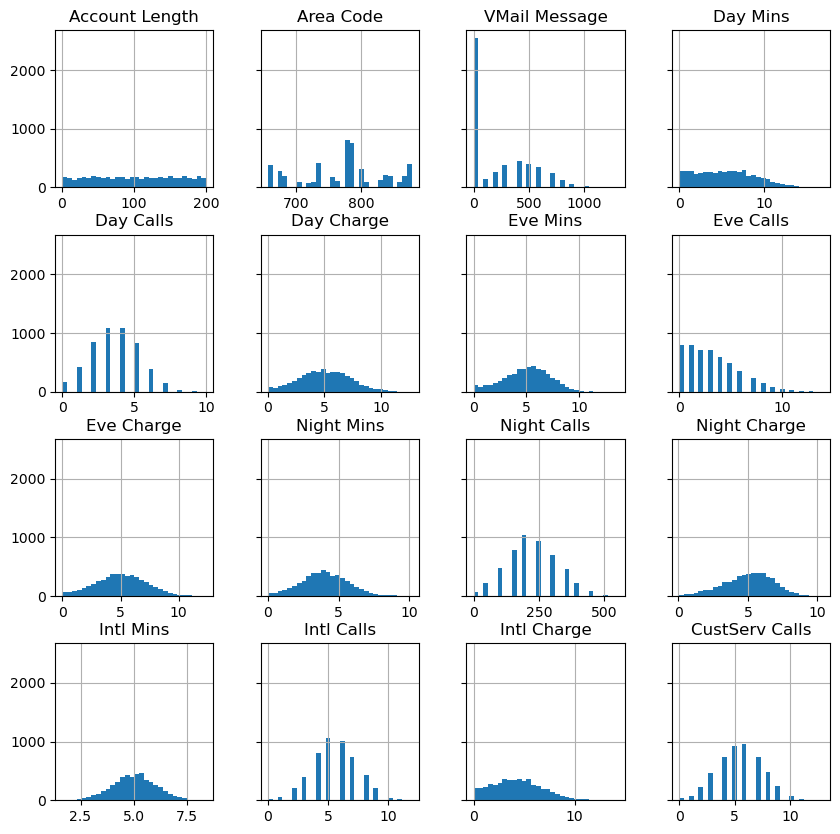

In [18]:
# Frequency tables for each categorical feature
for column in df.select_dtypes(include=["object"]).columns:  
    # Recorre todas las columnas categóricas (tipo object)
    display(pd.crosstab(
        index=df[column],                  # Valores únicos de la columna
        columns="% observations",             # Etiqueta de la columna resultante
        normalize="columns"                   # Muestra frecuencias relativas (%)
    ))

# Histograms for each numeric feature
display(df.describe())                      # Muestra estadísticas descriptivas de variables numéricas
# Asegura que los gráficos se muestren en el notebook
%matplotlib inline

hist = df.hist(bins=30, sharey=True, figsize=(10, 10))  
# Crea histogramas para todas las variables numéricas
# bins=30 → número de divisiones
# sharey=True → comparte escala del eje Y
# figsize → tamaño del gráfico


In [19]:
df_drop = df.drop("Phone", axis=1)
df_drop["Area Code"] = df_drop["Area Code"].astype(object)

Churn?,False.,True.
State,,
AK,0.015588,0.018415
AL,0.021583,0.018415
AR,0.022782,0.021217
AZ,0.015588,0.020416
CA,0.020384,0.021217
CO,0.018785,0.017614
CT,0.015588,0.020016
DC,0.022382,0.022418
DE,0.018385,0.018014


Churn?,False.,True.
Area Code,,
657,0.037170,0.036829
658,0.022782,0.021217
659,0.015588,0.020416
676,0.020384,0.021217
677,0.018785,0.017614
678,0.015588,0.020016
686,0.040767,0.040432
707,0.019984,0.015612
716,0.017986,0.015212


Churn?,False.,True.
Int'l Plan,,
no,0.5,0.502802
yes,0.5,0.497198


Churn?,False.,True.
VMail Plan,,
no,0.496403,0.498799
yes,0.503597,0.501201


Account Length


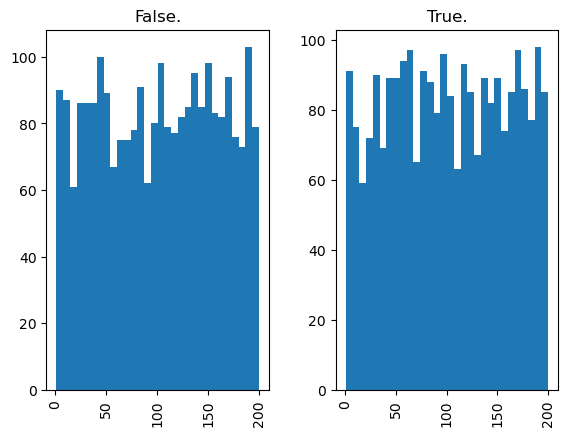

VMail Message


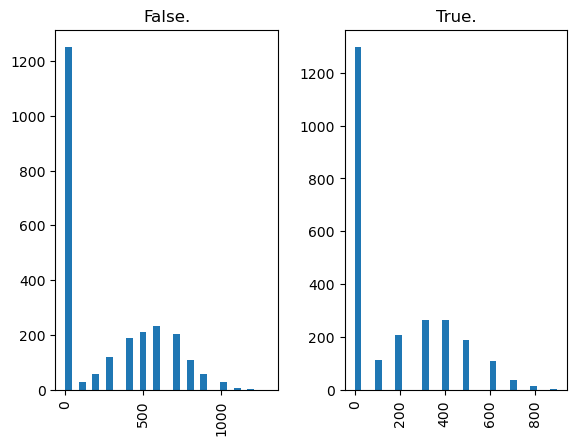

Day Mins


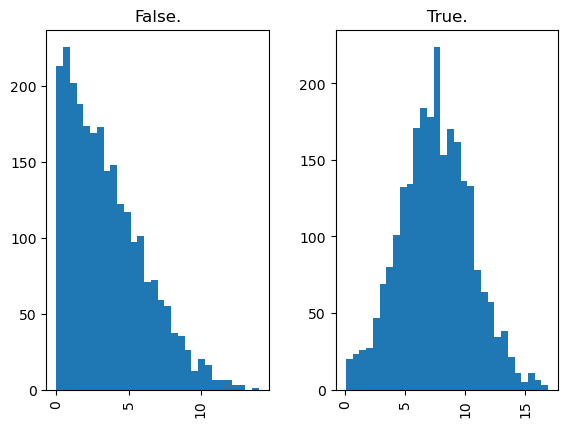

Day Calls


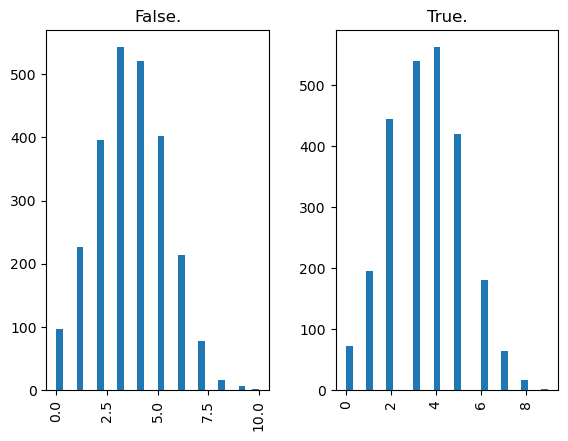

Day Charge


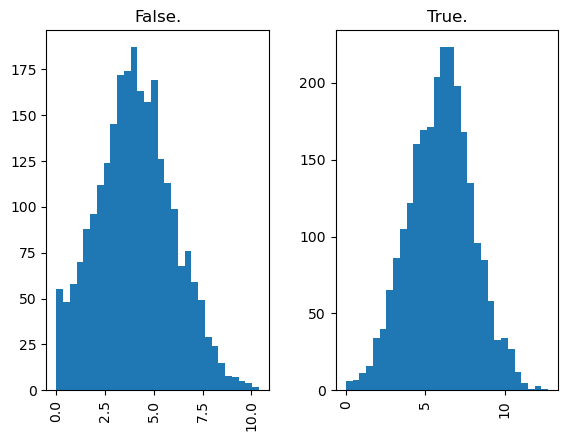

Eve Mins


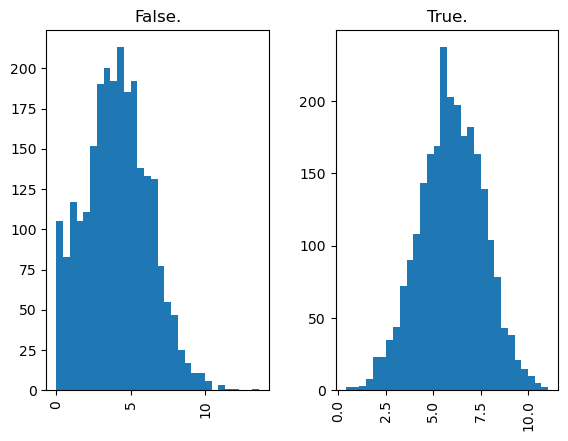

Eve Calls


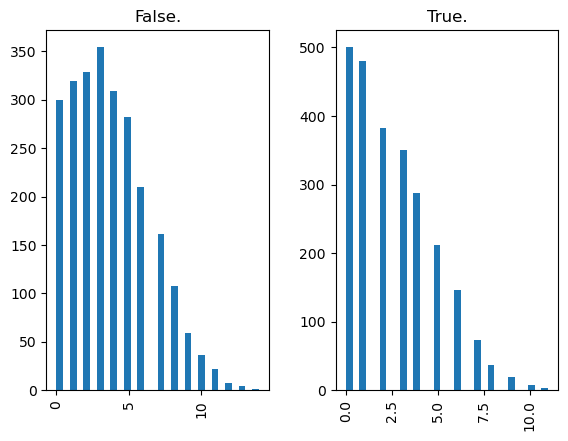

Eve Charge


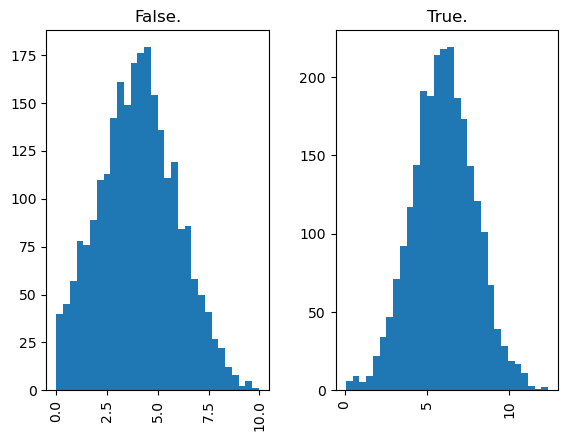

Night Mins


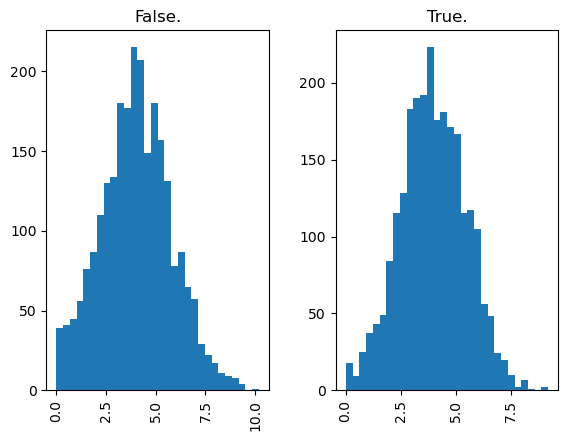

Night Calls


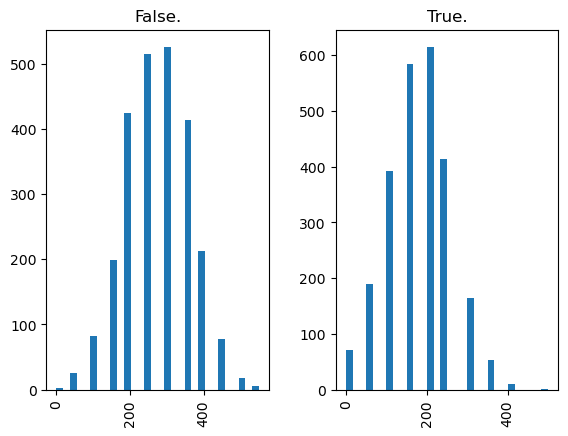

Night Charge


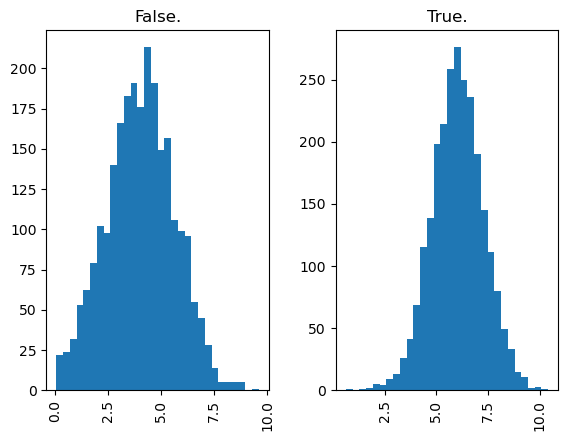

Intl Mins


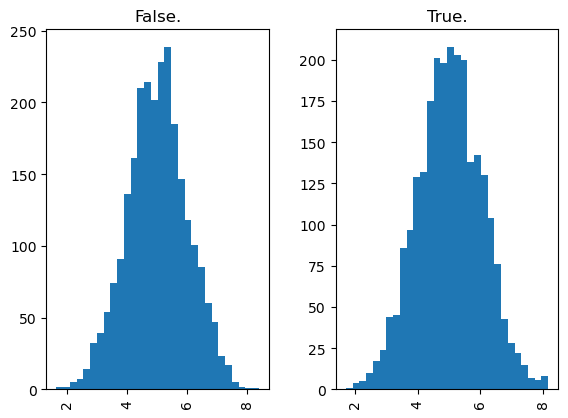

Intl Calls


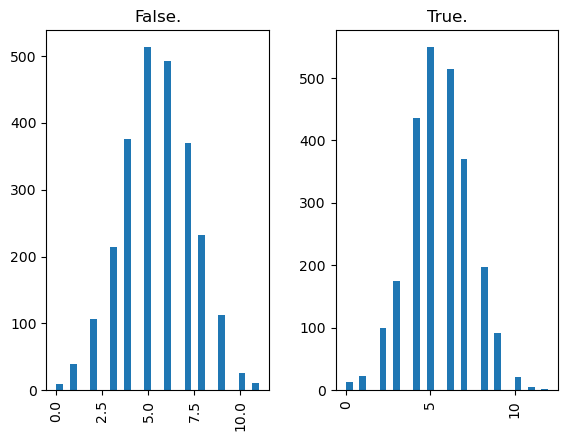

Intl Charge


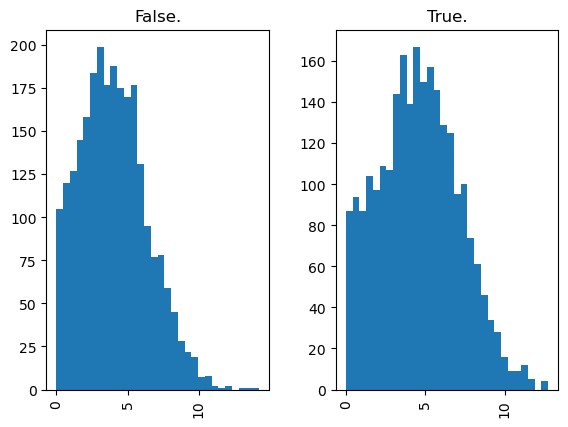

CustServ Calls


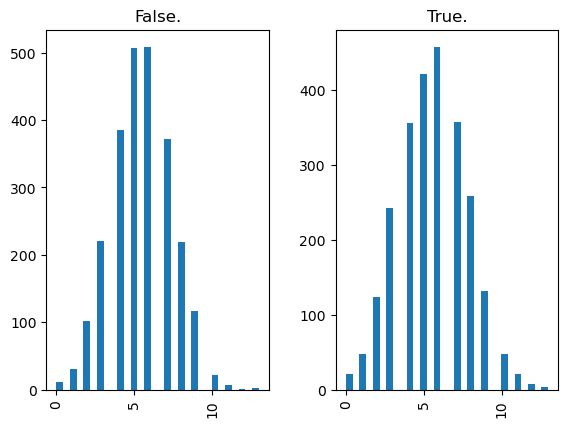

In [20]:
for column in df_drop.select_dtypes(include=["object"]).columns:
    if column != "Churn?":
        display(pd.crosstab(index=df_drop[column], columns=df_drop["Churn?"], normalize="columns"))

for column in df_drop.select_dtypes(exclude=["object"]).columns:
    print(column)
    hist = df_drop[[column, "Churn?"]].hist(by="Churn?", bins=30)
    plt.show()

,Account Length,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
Account Length,1.000000,-0.009030,-0.015878,0.011659,-0.007468,0.000213,0.026515,-0.012795,0.016400,-0.002383,-0.034925,0.017277,-0.003735,0.028285,-0.036721
VMail Message,-0.009030,1.000000,-0.143272,0.002762,-0.182712,-0.104667,-0.101240,-0.029212,0.061370,0.135042,-0.155475,-0.015162,0.131964,0.010120,0.068657
Day Mins,-0.015878,-0.143272,1.000000,-0.087598,0.667941,0.482641,-0.184939,0.766489,0.188190,-0.445212,0.570508,0.001988,0.236131,0.239331,-0.195322
Day Calls,0.011659,0.002762,-0.087598,1.000000,-0.222556,0.033903,0.185881,-0.052051,-0.085222,-0.083050,0.046641,-0.022548,-0.045671,-0.120064,-0.065518
Day Charge,-0.007468,-0.182712,0.667941,-0.222556,1.000000,0.574697,0.236626,0.371580,0.150700,-0.130722,0.374861,0.010294,0.119584,0.251748,-0.260945
Eve Mins,0.000213,-0.104667,0.482641,0.033903,0.574697,1.000000,-0.067123,0.269980,-0.090515,0.067315,0.317481,-0.015678,0.070456,0.448910,-0.167347
Eve Calls,0.026515,-0.101240,-0.184939,0.185881,0.236626,-0.067123,1.000000,-0.467814,0.221439,0.218149,-0.324936,-0.001593,-0.112062,0.017036,-0.433467
Eve Charge,-0.012795,-0.029212,0.766489,-0.052051,0.371580,0.269980,-0.467814,1.000000,0.184230,-0.454649,0.546137,-0.003569,0.164104,0.243936,-0.011019
Night Mins,0.016400,0.061370,0.188190,-0.085222,0.150700,-0.090515,0.221439,0.184230,1.000000,-0.223023,-0.140482,-0.012781,0.038831,0.271179,-0.332802
Night Calls,-0.002383,0.135042,-0.445212,-0.083050,-0.130722,0.067315,0.218149,-0.454649,-0.223023,1.000000,-0.390333,-0.009821,0.181237,-0.155736,0.110211


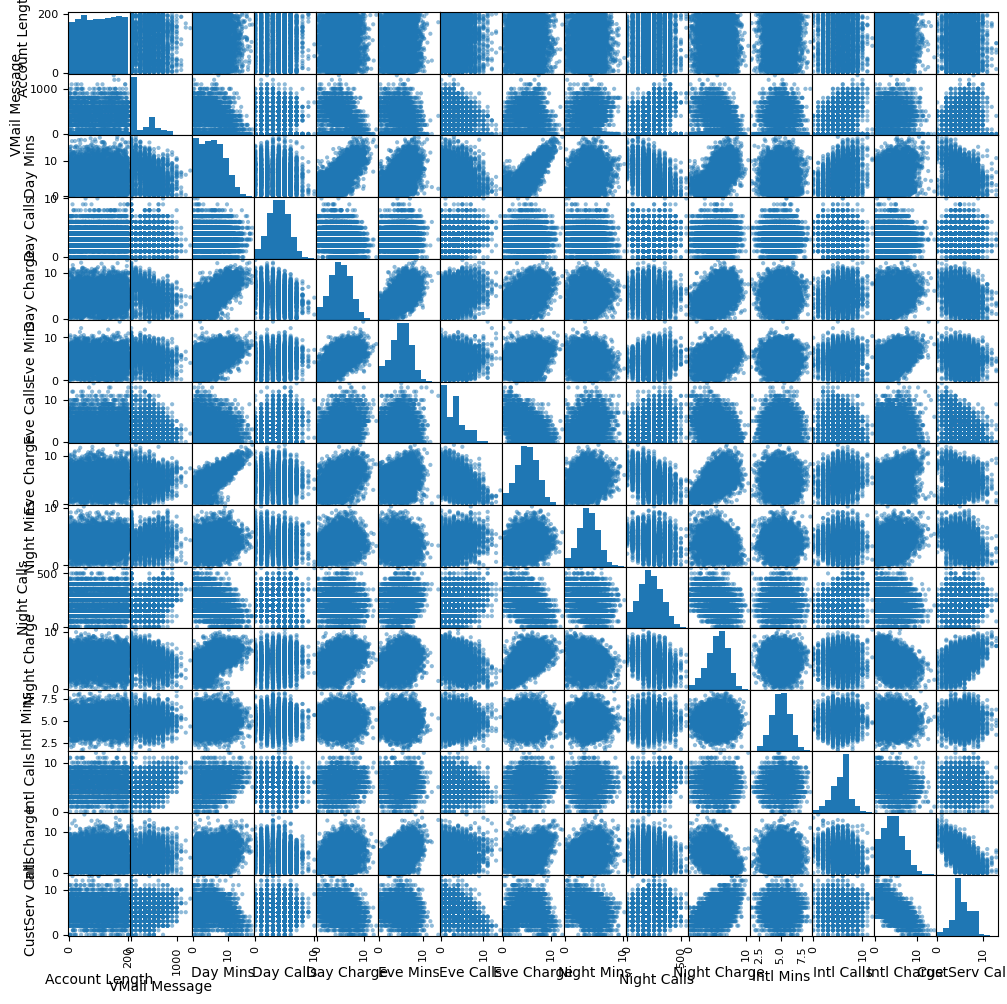

In [21]:
display(df_drop.corr(numeric_only=True))
pd.plotting.scatter_matrix(df_drop, figsize=(12, 12))
plt.show()

In [22]:
df_drop = df_drop.drop(["Day Charge", "Eve Charge", "Night Charge", "Intl Charge"], axis=1)

In [23]:
model_data = pd.get_dummies(df_drop)
model_data = pd.concat(
    [model_data["Churn?_True."], model_data.drop(["Churn?_False.", "Churn?_True."], axis=1)], axis=1
)
model_data = model_data.astype(float)
model_data.head()

,Churn?_True.,Account Length,VMail Message,Day Mins,Day Calls,Eve Mins,Eve Calls,Night Mins,Night Calls,Intl Mins,...,Area Code_858,Area Code_866,Area Code_868,Area Code_876,Area Code_877,Area Code_878,Int'l Plan_no,Int'l Plan_yes,VMail Plan_no,VMail Plan_yes
0,1.0,163.0,300.0,8.162204,3.0,3.933035,4.0,4.065759,100.0,4.928160,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.0,15.0,0.0,10.018993,4.0,2.325005,0.0,7.141040,200.0,3.221748,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,0.0,131.0,300.0,4.708490,3.0,4.537466,3.0,5.363235,100.0,7.139023,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.0,75.0,700.0,1.268734,3.0,2.528748,5.0,3.773586,450.0,2.245779,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
4,1.0,146.0,0.0,2.696177,3.0,6.015337,3.0,3.751673,250.0,6.905545,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


In [24]:
train_data, validation_data, test_data = np.split(
    model_data.sample(frac=1, random_state=1729),
    [int(0.7 * len(model_data)), int(0.9 * len(model_data))],
)
train_data.to_csv("train.csv", header=False, index=False)
validation_data.to_csv("validation.csv", header=False, index=False)

In [25]:
len(train_data.columns)

100

Subiendo datos de entrenamiento y valdación a S3

In [36]:
#len(test_data.columns)
#test_data.head()
columnas = test_data.columns.tolist()
print(columnas)


['Churn?_True.', 'Account Length', 'VMail Message', 'Day Mins', 'Day Calls', 'Eve Mins', 'Eve Calls', 'Night Mins', 'Night Calls', 'Intl Mins', 'Intl Calls', 'CustServ Calls', 'State_AK', 'State_AL', 'State_AR', 'State_AZ', 'State_CA', 'State_CO', 'State_CT', 'State_DC', 'State_DE', 'State_FL', 'State_GA', 'State_HI', 'State_IA', 'State_ID', 'State_IL', 'State_IN', 'State_KS', 'State_KY', 'State_LA', 'State_MA', 'State_MD', 'State_ME', 'State_MI', 'State_MN', 'State_MO', 'State_MS', 'State_MT', 'State_NC', 'State_ND', 'State_NE', 'State_NH', 'State_NJ', 'State_NM', 'State_NV', 'State_NY', 'State_OH', 'State_OK', 'State_OR', 'State_PA', 'State_RI', 'State_SC', 'State_SD', 'State_TN', 'State_TX', 'State_UT', 'State_VA', 'State_VT', 'State_WA', 'State_WI', 'State_WV', 'State_WY', 'Area Code_657', 'Area Code_658', 'Area Code_659', 'Area Code_676', 'Area Code_677', 'Area Code_678', 'Area Code_686', 'Area Code_707', 'Area Code_716', 'Area Code_727', 'Area Code_736', 'Area Code_737', 'Area Co

In [16]:
boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "train/train.csv")
).upload_file("train.csv")
boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "validation/validation.csv")
).upload_file("validation.csv")


Se especifíca la localización del XGBoost algorithm 

**TRAINING**

locations of the XGBoost algorithm containers

In [18]:
s3_input_train = TrainingInput(
    s3_data="s3://{}/{}/train".format(bucket, prefix), content_type="csv"
)
s3_input_validation = TrainingInput(
    s3_data="s3://{}/{}/validation/".format(bucket, prefix), content_type="csv"
)

In [19]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    output_path="s3://{}/{}/output".format(bucket, prefix),
    sagemaker_session=sess,
)
xgb.set_hyperparameters(
    max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.8,
    verbosity=0,
    objective="binary:logistic",
    num_round=100,
)

#xgb.fit({"train": s3_input_train, "validation": s3_input_validation})

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2025-12-01-02-55-03-387


2025-12-01 02:55:04 Starting - Starting the training job...
2025-12-01 02:55:30 Starting - Preparing the instances for training......
2025-12-01 02:56:10 Downloading - Downloading input data...
2025-12-01 02:56:40 Downloading - Downloading the training image......
2025-12-01 02:58:01 Training - Training image download completed. Training in progress../miniconda3/lib/python3.9/site-packages/sagemaker_containers/_server.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
[2025-12-01 02:58:09.198 ip-10-0-160-54.ec2.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2025-12-01 02:58:09.270 ip-10-0-160-54.ec2.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2025-12-01:02:58:09:INFO] Imported framework sagemaker_xgboost_container.trai

## Host

*Create a model and deploy it to a hosted endpoint*

In [6]:
import sagemaker
from sagemaker.estimator import Estimator

sess = sagemaker.Session()
role = sagemaker.get_execution_role()  # si estás en SageMaker Notebook Instance / Studio

# 1. Adjuntar el Estimator al training job ya existente
xgb = Estimator.attach(
    training_job_name="sagemaker-xgboost-2025-12-01-02-55-03-387",
    sagemaker_session=sess
)


2025-12-01 02:58:30 Starting - Preparing the instances for training
2025-12-01 02:58:30 Downloading - Downloading the training image
2025-12-01 02:58:30 Training - Training image download completed. Training in progress.
2025-12-01 02:58:30 Uploading - Uploading generated training model
2025-12-01 02:58:30 Completed - Training job completed


In [7]:
xgb_predictor = xgb.deploy(
    initial_instance_count=1,
    instance_type="ml.m4.xlarge",
    serializer=CSVSerializer(),
    endpoint_name="churn-xgboost-prod-v1"
)

-------!

In [21]:
# xgb_predictor.delete_endpoint()


## Testeo

In [30]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ""
    for array in split_array:
        predictions = "".join([predictions, xgb_predictor.predict(array).decode("utf-8")])

    return predictions.split("\n")[:-1]


predictions = predict(test_data.to_numpy()[:, 1:])

In [31]:
predictions = np.array([float(num) for num in predictions])
print(predictions)

[1.45354465e-01 9.78284001e-01 2.29995721e-03 4.43856046e-03
 4.18119103e-01 9.61098611e-01 9.88697410e-01 7.09247828e-01
 9.00699615e-01 9.90865409e-01 9.16577816e-01 9.16562043e-03
 1.32644475e-02 9.32690680e-01 9.90951777e-01 9.90174174e-01
 9.90583062e-01 6.71710148e-02 9.68500853e-01 9.88211036e-01
 9.49407101e-01 3.49131855e-03 6.24201074e-03 9.03135717e-01
 9.15755212e-01 3.02289635e-01 9.91930068e-01 1.00098653e-02
 9.89490330e-01 2.89308596e-02 3.35139036e-02 4.30867486e-02
 9.57395673e-01 7.48302042e-03 4.56276210e-03 2.22346629e-03
 6.68902099e-01 3.98493201e-01 9.89661694e-01 9.71789002e-01
 8.21430683e-01 9.90990996e-01 4.96863037e-01 9.68719840e-01
 2.86707142e-03 9.22252357e-01 8.58608517e-04 1.73726588e-01
 9.83624935e-01 4.02040966e-03 1.40238460e-02 9.71329868e-01
 9.67991769e-01 1.32331580e-01 1.07120641e-01 9.92310762e-01
 2.77149454e-02 4.27350076e-03 9.49290674e-03 2.99536940e-02
 3.51974726e-01 9.51662481e-01 9.29118633e-01 3.48184891e-02
 1.18576223e-02 9.741264

In [31]:
conf_matrix = pd.crosstab(
    index=test_data.iloc[:, 0],
    columns=np.round(predictions),
    rownames=["actual"],
    colnames=["predictions"],
)
conf_matrix

predictions,0.0,1.0
actual,,
0.0,235,18
1.0,11,236


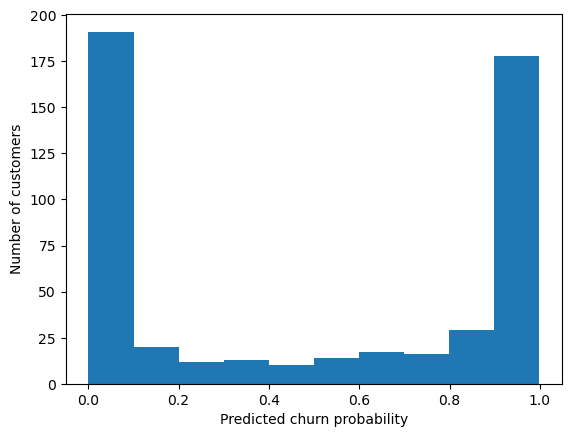

In [41]:
plt.hist(predictions)
plt.xlabel("Predicted churn probability")
plt.ylabel("Number of customers")
plt.show()

In [45]:
conf_matrix = pd.crosstab(index=test_data.iloc[:, 0], columns=np.where(predictions > 0.3, 1, 0))

In [48]:
# Extraer TP, TN, FP, FN
TN = conf_matrix.loc[0, 0]
FP = conf_matrix.loc[0, 1]
FN = conf_matrix.loc[1, 0]
TP = conf_matrix.loc[1, 1]

# Métricas
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
precision = TP / (TP + FP)
accuracy = (TP + TN) / (TP + TN + FP + FN)
f1 = 2 * (precision * sensitivity) / (precision + sensitivity)

print(f"Sensitivity (Recall / True Positive Rate = TP/(TP+FN)): {sensitivity:.4f} "
      "- Capacidad del modelo para detectar correctamente los casos positivos reales (clientes que sí hacen churn).\n")

print(f"Specificity (True Negative Rate = TN/(TN+FP)): {specificity:.4f} "
      "- Capacidad del modelo para identificar correctamente los casos negativos (clientes que NO hacen churn).\n")

print(f"Precision (Positive Predictive Value = TP/(TP+FP)): {precision:.4f} "
      "- Probabilidad de que los clientes predichos como churn realmente lo sean.\n")

print(f"Accuracy ((TP+TN)/(TP+TN+FP+FN)): {accuracy:.4f} "
      "- Porcentaje total de predicciones correctas del modelo.\n")

print(f"F1-score (2 * (Precision * Recall) / (Precision + Recall)): {f1:.4f} "
      "- Balance entre precisión y sensibilidad; útil cuando la clase positiva es poco frecuente.\n")



Sensitivity (Recall / True Positive Rate = TP/(TP+FN)): 0.9919 - Capacidad del modelo para detectar correctamente los casos positivos reales (clientes que sí hacen churn).

Specificity (True Negative Rate = TN/(TN+FP)): 0.8735 - Capacidad del modelo para identificar correctamente los casos negativos (clientes que NO hacen churn).

Precision (Positive Predictive Value = TP/(TP+FP)): 0.8845 - Probabilidad de que los clientes predichos como churn realmente lo sean.

Accuracy ((TP+TN)/(TP+TN+FP+FN)): 0.9320 - Porcentaje total de predicciones correctas del modelo.

F1-score (2 * (Precision * Recall) / (Precision + Recall)): 0.9351 - Balance entre precisión y sensibilidad; útil cuando la clase positiva es poco frecuente.



## Finding the optimal cutoff

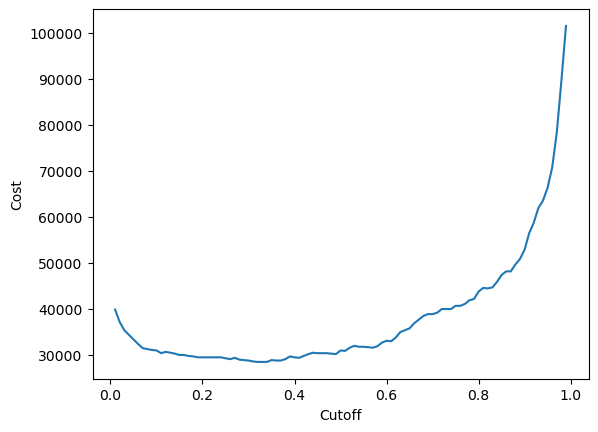

In [49]:
cutoffs = np.arange(0.01, 1, 0.01)
costs = []
for c in cutoffs:
    costs.append(
        np.sum(
            np.sum(
                np.array([[0, 100], [500, 100]])
                * pd.crosstab(index=test_data.iloc[:, 0], columns=np.where(predictions > c, 1, 0))
            )
        )
    )

costs = np.array(costs)
plt.plot(cutoffs, costs)
plt.xlabel("Cutoff")
plt.ylabel("Cost")
plt.show()

In [28]:
print(
    "Cost is minimized near a cutoff of:",
    cutoffs[np.argmin(costs)],
    "for a cost of:",
    np.min(costs),
)

Cost is minimized near a cutoff of: 0.32 for a cost of: 28400


## Maquina de recomendaciones

In [50]:
# BLOQUE FINAL: SISTEMA DE RECOMENDACIONES (Next Best Action)

# 1. Recuperamos los datos originales (con precios, minutos, planes)
# Usamos el mismo random_state=1729 para asegurar que sean LAS MISMAS personas del test_data
train_df_orig, val_df_orig, test_df_orig = np.split(
    df.sample(frac=1, random_state=1729), 
    [int(0.7 * len(df)), int(0.9 * len(df))]
)

# Preparamos el DataFrame de resultados uniendo la realidad con la predicción
df_recomendaciones = test_df_orig.copy()

# Aseguramos que 'predictions' tenga el formato correcto
# (Si predictions ya existe de celdas anteriores, lo usamos directamenente)
df_recomendaciones['Probabilidad_Fuga'] = predictions

# Definimos el Cerebro de Recomendaciones (Reglas de Negocio)
def motor_de_recomendacion(fila):
    """
    Analiza las columnas originales del cliente para personalizar la oferta.
    """
    # Regla 1: Cliente frustrado (muchas llamadas a soporte)
    if fila['CustServ Calls'] > 3:
        return "Trato VIP: Asignar gestor personal + Prioridad en atención"
    
    # Regla 2: Cliente que gasta mucho (VIP Económico)
    # Sumamos todos los cargos (Día + Noche + Internacional)
    gasto_total = fila['Day Charge'] + fila['Eve Charge'] + fila['Night Charge'] + fila['Intl Charge']
    if gasto_total > 70: # Umbral de gasto alto
        return "Retención Financiera: 25% de descuento en la factura x 6 meses"
    
    # Regla 3: Usuario Internacional (Viajero o familia fuera)
    if fila['Intl Calls'] > 4 or fila["Int'l Plan"] == 'yes':
        return "Pack Viajero: Bonificación de 200 minutos internacionales"
    
    # Regla 4: Usuario de Datos/Voz intensivo (Habla mucho de día)
    if fila['Day Mins'] > 220:
        return "Upgrade Tecnológico: Oferta de renovación de equipo (Smartphone)"

    # Regla por defecto (Para los demás casos de riesgo)
    return "Incentivo General: 3 meses de Amazon Prime Video gratis"

# Filtramos los clientes en riesgo (Umbral > 0.32) y aplicamos recomendaciones
# Creamos una vista limpia solo con los clientes que nos preocupan
reporte_final = df_recomendaciones[df_recomendaciones['Probabilidad_Fuga'] > 0.32].copy()

# Aplicamos la función inteligente fila por fila
reporte_final['Accion_Recomendada'] = reporte_final.apply(motor_de_recomendacion, axis=1)

# Mostramos el resultado bonito
pd.set_option('display.max_colwidth', None) # Para leer todo el texto
columnas_a_mostrar = ['State', 'CustServ Calls', 'Day Charge', 'Intl Calls', 'Probabilidad_Fuga', 'Accion_Recomendada']

print(f"Total de clientes analizados: {len(df_recomendaciones)}")
print(f"Clientes en Riesgo detectados: {len(reporte_final)}")
print("\n--- TOP 10 RECOMENDACIONES GENERADAS ---")
display(reporte_final[columnas_a_mostrar].head(10))

Total de clientes analizados: 500
Clientes en Riesgo detectados: 274

--- TOP 10 RECOMENDACIONES GENERADAS ---


,State,CustServ Calls,Day Charge,Intl Calls,Probabilidad_Fuga,Accion_Recomendada
3567,MN,3,10.155415,5,0.978284,Pack Viajero: Bonificación de 200 minutos internacionales
1024,ID,9,4.364444,5,0.418119,Trato VIP: Asignar gestor personal + Prioridad en atención
4495,AR,3,9.957552,4,0.961099,Pack Viajero: Bonificación de 200 minutos internacionales
4403,AK,2,7.546739,6,0.988697,Pack Viajero: Bonificación de 200 minutos internacionales
559,DE,10,3.936483,6,0.709248,Trato VIP: Asignar gestor personal + Prioridad en atención
3320,NV,7,4.108802,6,0.900700,Trato VIP: Asignar gestor personal + Prioridad en atención
1617,NE,6,8.950403,5,0.990865,Trato VIP: Asignar gestor personal + Prioridad en atención
1331,MD,5,4.837997,6,0.916578,Trato VIP: Asignar gestor personal + Prioridad en atención
978,DC,9,6.006336,4,0.932691,Trato VIP: Asignar gestor personal + Prioridad en atención
1185,MT,3,7.611705,7,0.990952,Pack Viajero: Bonificación de 200 minutos internacionales


In [ ]:
#xgb_predictor.delete_endpoint()

In [33]:
import numpy as np

# 1. Datos de entrada proporcionados por el usuario (como un string con 100 valores)
raw_input_string = "1.0,2.0,400.0,0.3857184604012253,2.0,4.177940384158745,0.0,3.745462710628048,250.0,3.699591756294294,1.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0"

# 2. Convertir el string a un array de NumPy
#    a) Separar el string por comas
#    b) Convertir cada elemento a float
#    c) Convertir la lista resultante en un array de NumPy
numeric_values = np.array([float(x) for x in raw_input_string.split(',')])

# 3. Preparar los datos para la predicción
#    Aplicamos el slicing [1:] para eliminar la columna de la etiqueta (target) 
#    en la posición 0, dejando solo las 99 características.
single_row_features = numeric_values[1:]

# 4. Darle la forma de "matriz de una sola fila" (1, 99) que la función 'predict' espera
#    Tu función 'predict' itera sobre arrays, por lo que necesita que la entrada tenga dos dimensiones.
input_for_predict = single_row_features.reshape(1, -1)

# 5. Ejecutar la predicción
prediction_result = predict(input_for_predict)

# 6. Mostrar el resultado
probabilidad_fuga = float(prediction_result[0])

print(f"Probabilidad de Fuga: {probabilidad_fuga:.4f}")

# Opcional: Usando el umbral óptimo encontrado (0.32)
if probabilidad_fuga > 0.32:
    print("El cliente tiene ALTO RIESGO de fuga (> 0.32).")
else:
    print("El cliente tiene BAJO RIESGO de fuga.")

Probabilidad de Fuga: 0.9620
El cliente tiene ALTO RIESGO de fuga (> 0.32).
